In [1]:
!mkdir -p model
# !pip install scikit-plot > /dev/null
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
!pip install -q scikit-plot

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
You should consider upgrading via the '/homes/nv304/virtpy3/bin/python -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import os,time
import cv2
import keras
from keras import backend as K
from keras import layers
from keras import models
from keras.datasets import mnist
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import pandas as pd
from tensorflow.keras.utils import plot_model

Using TensorFlow backend.
/homes/nv304/virtpy3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/homes/nv304/virtpy3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/homes/nv304/virtpy3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/homes/nv304/virtpy3/lib/python3.6/site-packages/tensorflow/py

In [4]:
from numba import cuda

In [5]:
batch_size = 128
buffer_size = 10000
steps_per_epoch = int(np.ceil(60000 / float(batch_size)))  # = 469
epochs = 10
result = pd.DataFrame()

In [6]:
def get_dataset(dataset_name,final_shape=(32,32),classes=10):
    if dataset_name == "mnist":
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33, shuffle=True ,random_state=42)
        
        pad_0 = int((final_shape[0]-28)/2)
        pad_1 = int((final_shape[1]-28)/2)
        
        x_train = x_train.astype('float32')        
        x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
        x_train = np.pad(x_train, ((0,0),(pad_0,pad_1),(pad_0,pad_1),(0,0)), 'constant')
        x_train = np.stack((x_train,)*3, axis=-1)
        x_train = x_train[:,:,:,0,:]
        
        x_test = x_test.astype('float32')
        x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
        x_test = np.pad(x_test, ((0,0),(pad_0,pad_1),(pad_0,pad_1),(0,0)), 'constant')
        x_test = np.stack((x_test,)*3, axis=-1)
        x_test = x_test[:,:,:,0,:]
        
        x_val = x_val.astype('float32')
        x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)
        x_val = np.pad(x_val, ((0,0),(pad_0,pad_1),(pad_0,pad_1),(0,0)), 'constant')
        x_val = np.stack((x_val,)*3, axis=-1)
        x_val = x_val[:,:,:,0,:]
        
        y_train = keras.utils.to_categorical(y_train, classes)
        y_test = keras.utils.to_categorical(y_test, classes)
        y_val = keras.utils.to_categorical(y_val, classes)
        
    if dataset_name == "cifar10":
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33, shuffle=True ,random_state=42)

        pad_0 = int((final_shape[0]-32)/2)
        pad_1 = int((final_shape[1]-32)/2)
        
        x_train = x_train.astype('float32')        
        x_train = np.pad(x_train, ((0,0),(pad_0,pad_1),(pad_0,pad_1),(0,0)), 'constant')
        
        x_val = x_val.astype('float32')
        x_val = np.pad(x_val, ((0,0),(pad_0,pad_1),(pad_0,pad_1),(0,0)), 'constant')
        
        x_test = x_test.astype('float32')
        x_test = np.pad(x_test, ((0,0),(pad_0,pad_1),(pad_0,pad_1),(0,0)), 'constant')
        
        y_train = keras.utils.to_categorical(y_train, classes)
        y_test = keras.utils.to_categorical(y_test, classes)
        y_val = keras.utils.to_categorical(y_val, classes)
        
    return x_train, x_test, x_val, y_train, y_test, y_val

(x_train, x_test, x_val, y_train, y_test, y_val) = get_dataset("mnist",final_shape=(32,32),classes=10)
print(x_train.shape,y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape,y_test.shape)

(40200, 32, 32, 3) (40200, 10)
(19800, 32, 32, 3) (19800, 10)
(10000, 32, 32, 3) (10000, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


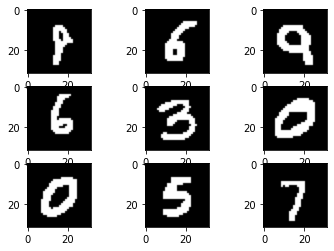

In [7]:
import random
%matplotlib inline

# index = random.randint(0, len(data.x_train))
# image = data.x_train[index].squeeze()

# plt.figure(figsize=(5,5))
# plt.imshow(image, cmap="gray")
# print(y_train[index])
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap="gray")
plt.show()

In [8]:
def inception(x, filters):
    # 1x1
    path1 = layers.Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = layers.Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = layers.Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = layers.Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = layers.Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = layers.MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = layers.Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return layers.Concatenate(axis=-1)([path1,path2,path3,path4])


def auxiliary(x, classes,name=None):
    layer = layers.AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = layers.Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = layers.Flatten()(layer)
    layer = layers.Dense(units=256, activation='relu')(layer)
    layer = layers.Dropout(0.4)(layer)
    layer = layers.Dense(units=classes, activation='softmax', name=name)(layer)
    return layer


def get_model(input_shape,classes=10,d_rate=0.2,act='softmax'):
    inputs = layers.Input(shape=input_shape)
    layer = layers.Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(inputs)
    layer = layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = layers.BatchNormalization()(layer)

    # stage-2
    layer = layers.Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = layers.Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-3
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-4
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer, classes, name='aux1')
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer, classes, name='aux2')
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-5
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = layers.AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    # stage-6
    layer = layers.Flatten()(layer)
    layer = layers.Dropout(d_rate)(layer)
    layer = layers.Dense(units=256, activation='linear')(layer)
    main = layers.Dense(units=classes, activation=act, name='main')(layer)
    model = models.Model(inputs=inputs, outputs=[main, aux1, aux2])
    return model

In [9]:
def get_optimiser(opt,learning_rate):
    if opt=='sgd':
        opt_type = keras.optimizers.SGD(lr=learning_rate,decay=1e-6,momentum=0.9,nesterov=True)
    if opt=='adagrad':
        opt_type = keras.optimizers.Adagrad(lr=learning_rate,epsilon=1e-08)
    if opt=='adam':
        opt_type = keras.optimizers.Adam(lr=learning_rate,beta_1=0.9,beta_2=0.999,epsilon=1e-08,amsgrad=False)
    return opt_type

## MNIST

In [10]:
learning_rate = 0.01
d_rate = 0.2
act = 'softmax'
opt = 'sgd'
classes = 10
dataset = "mnist"
input_dims = (224,224)
print("**Selecting Dataset", dataset)
print("**Coverting ",dataset," to 3 channel dims ",str(input_dims))
x_train, x_test, x_val, y_train, y_test, y_val = get_dataset(dataset,final_shape=input_dims)
print("**Dataset Dimensions:")
print("**Training Dataset Dims: ",x_train.shape,y_train.shape)
print("**Validation Dataset Dims: ",x_val.shape,y_val.shape)
print("**Test Dataset Dims: ",x_test.shape,y_test.shape)


**Selecting Dataset mnist
**Coverting  mnist  to 3 channel dims  (224, 224)
**Dataset Dimensions:
**Training Dataset Dims:  (40200, 224, 224, 3) (40200, 10)
**Validation Dataset Dims:  (19800, 224, 224, 3) (19800, 10)
**Test Dataset Dims:  (10000, 224, 224, 3) (10000, 10)


In [11]:
input_shape = x_train.shape[1:]
print("**Creating GoogLeNet network")
inputs = layers.Input(shape=input_shape)
model = get_model(input_shape,classes,d_rate,act)
print("**Selecting Optimiser", opt," with Learning rate ",learning_rate)
opt_type = get_optimiser(opt,learning_rate)

model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt_type,metrics=['accuracy'])
plot_model(model, to_file='model/inception.png')

print(model.summary())

print("**Starting Training..")
start = time.time()
history = model.fit(x_train, [y_train,y_train,y_train],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, [y_val,y_val,y_val]))
end = time.time()
total_exec_time = end - start
print("**Total Execution time", total_exec_time)

**Creating GoogLeNet network
Instructions for updating:
Colocations handled automatically by placer.
**Selecting Optimiser sgd  with Learning rate  0.01
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 56, 56, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None,

In [12]:
print("Saving Network and weights")
weight_path = 'model/inception_wt.h5'
model.save_weights(weight_path)

Saving Network and weights


In [14]:
print("Evaluating network performance on Test Data")
score = model.evaluate(x_test, [y_test,y_test,y_test], verbose=1,batch_size=batch_size)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Evaluating network performance on Test Data
10000/10000 [==============================] - 16s 2ms/step
Test loss: 6.125518496704101
Test accuracy: 2.3052423000335693


In [17]:
history.history

{'val_loss': [6.385513384655268],
 'val_main_loss': [2.4066152572631836],
 'val_aux1_loss': [1.3943676948547363],
 'val_aux2_loss': [2.586168050765991],
 'val_main_accuracy': [0.4580303132534027],
 'val_aux1_accuracy': [0.6059595942497253],
 'val_aux2_accuracy': [0.3758585751056671],
 'loss': [3.373990041865638],
 'main_loss': [1.2311724],
 'aux1_loss': [0.9584502],
 'aux2_loss': [1.177446],
 'main_accuracy': [0.55452734],
 'aux1_accuracy': [0.674602],
 'aux2_accuracy': [0.5842786]}

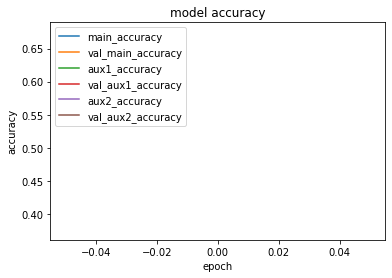

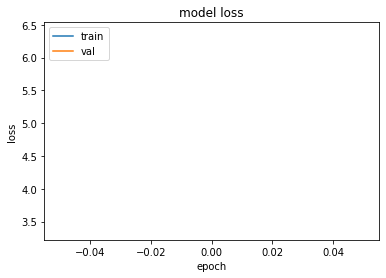

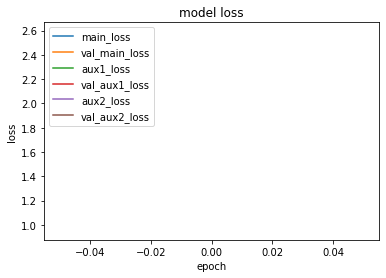

In [16]:
plt.plot(history.history['main_accuracy'])
plt.plot(history.history['val_main_accuracy'])
plt.plot(history.history['aux1_accuracy'])
plt.plot(history.history['val_aux1_accuracy'])
plt.plot(history.history['aux2_accuracy'])
plt.plot(history.history['val_aux2_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['main_accuracy', 'val_main_accuracy','aux1_accuracy','val_aux1_accuracy','aux2_accuracy','val_aux2_accuracy'], loc='upper left')
plt.show()
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['main_loss'])
plt.plot(history.history['val_main_loss'])
plt.plot(history.history['aux1_loss'])
plt.plot(history.history['val_aux1_loss'])
plt.plot(history.history['aux2_loss'])
plt.plot(history.history['val_aux2_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['main_loss', 'val_main_loss','aux1_loss','val_aux1_loss','aux2_loss','val_aux2_loss'], loc='upper left')
plt.show()

In [18]:
predictions = model.predict(x_test, verbose=0)

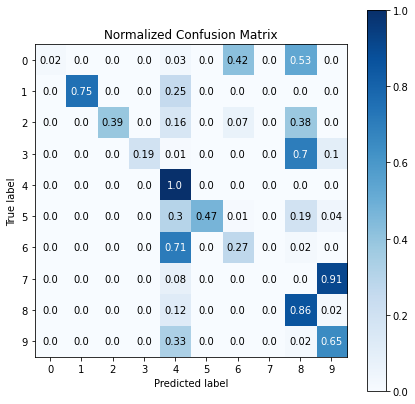

In [20]:
# from sklearn.metrics import classification_report, confusion_matrix
# confusion_matrix(np.argmax(data.y_test,axis=1),np.argmax(predictions,axis=1))
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(np.argmax(y_test,axis=1),np.argmax(predictions[0],axis=1), normalize=True,figsize = (7,7))

In [24]:
def test_accuracy():
    err = []
    tru = []
    for i in range(len(predictions[0])):
        if np.argmax(predictions[0][i]) == np.argmax(y_test[i]):
            tru.append(i)
        else:
            err.append(i)
    return tru, err

p = test_accuracy()

# plt.subplot(330 + 1 + i)
# plt.imshow(x_train[i], cmap="gray")
print("True:          {}".format(np.argmax(y_test[p[0][0:5]], axis =1)))
print("classified as: {}".format(np.argmax(predictions[0][p[0][0:5]], axis=1)))
print("Error Cases")
print("True:          {}".format(np.argmax(y_test[p[1][6:11]], axis =1)))
print("classified as: {}".format(np.argmax(predictions[0][p[1][6:11]], axis=1)))

True:          [2 1 4 1 4]
classified as: [2 1 4 1 4]
Error Cases
True:          [0 7 3 6 5]
classified as: [8 9 8 4 4]


In [ ]:
K.clear_session()

## CIFAR10

In [14]:
learning_rate = 0.01
d_rate = 0.2
act = 'softmax'
opt = 'sgd'
classes = 10
dataset = "cifar10"
input_dims = (224,224)
print("**Selecting Dataset", dataset)
print("**Coverting ",dataset," to 3 channel dims ",str(input_dims))
x_train, x_test, x_val, y_train, y_test, y_val = get_dataset(dataset,final_shape=input_dims)
print("**Dataset Dimensions:")
print("**Training Dataset Dims: ",x_train.shape,y_train.shape)
print("**Validation Dataset Dims: ",x_val.shape,y_val.shape)
print("**Test Dataset Dims: ",x_test.shape,y_test.shape)


**Selecting Dataset cifar10
**Coverting  cifar10  to 3 channel dims  (224, 224)
**Dataset Dimensions:
**Training Dataset Dims:  (33500, 224, 224, 3) (33500, 10)
**Validation Dataset Dims:  (16500, 224, 224, 3) (16500, 10)
**Test Dataset Dims:  (10000, 224, 224, 3) (10000, 10)


In [15]:
input_shape = x_train.shape[1:]
print("**Creating GoogLeNet network")
inputs = layers.Input(shape=input_shape)
model = get_model(input_shape,classes,d_rate,act)
print("**Selecting Optimiser", opt," with Learning rate ",learning_rate)
opt_type = get_optimiser(opt,learning_rate)

model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt_type,metrics=['accuracy'])
plot_model(model, to_file='model/inception.png')

print(model.summary())

print("**Starting Training..")
start = time.time()
history = model.fit(x_train, [y_train,y_train,y_train],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, [y_val,y_val,y_val]))
end = time.time()
total_exec_time = end - start
print("**Total Execution time", total_exec_time)

**Creating GoogLeNet network
**Selecting Optimiser sgd  with Learning rate  0.01
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 112, 112, 64) 9472        input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 56, 56, 64)   0           conv2d_43[0][0]                  
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 56, 56, 64)   256         max_pooling2d_13[0][0]           
___________

In [16]:
print("Saving Network and weights")
weight_path = 'model/inception_wt.h5'
model.save_weights(weight_path)

Saving Network and weights


In [17]:
print("Evaluating network performance on Test Data")
score = model.evaluate(x_test, [y_test,y_test,y_test], verbose=1,batch_size=batch_size)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Evaluating network performance on Test Data
10000/10000 [==============================] - 15s 1ms/step
Test loss: 9.969993832397462
Test accuracy: 3.441102981567383


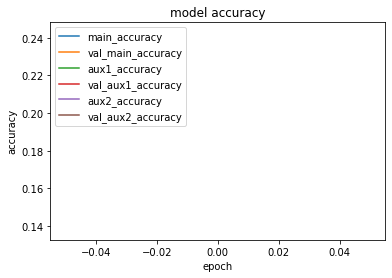

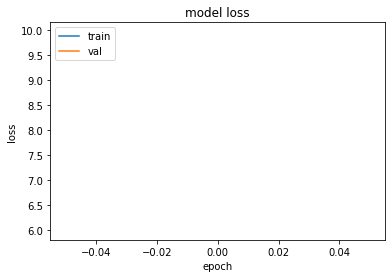

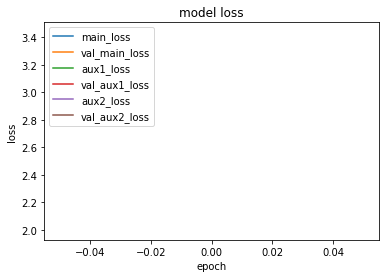

In [18]:
plt.plot(history.history['main_accuracy'])
plt.plot(history.history['val_main_accuracy'])
plt.plot(history.history['aux1_accuracy'])
plt.plot(history.history['val_aux1_accuracy'])
plt.plot(history.history['aux2_accuracy'])
plt.plot(history.history['val_aux2_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['main_accuracy', 'val_main_accuracy','aux1_accuracy','val_aux1_accuracy','aux2_accuracy','val_aux2_accuracy'], loc='upper left')
plt.show()
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['main_loss'])
plt.plot(history.history['val_main_loss'])
plt.plot(history.history['aux1_loss'])
plt.plot(history.history['val_aux1_loss'])
plt.plot(history.history['aux2_loss'])
plt.plot(history.history['val_aux2_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['main_loss', 'val_main_loss','aux1_loss','val_aux1_loss','aux2_loss','val_aux2_loss'], loc='upper left')
plt.show()

In [19]:
predictions = model.predict(x_test, verbose=0)

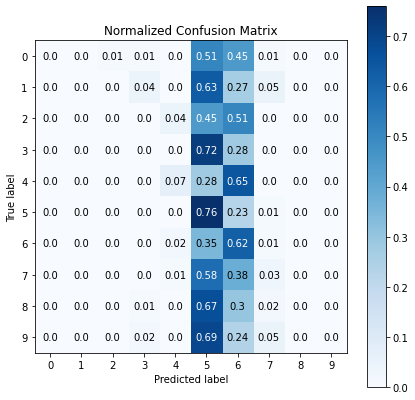

In [20]:
# from sklearn.metrics import classification_report, confusion_matrix
# confusion_matrix(np.argmax(data.y_test,axis=1),np.argmax(predictions,axis=1))
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(np.argmax(y_test,axis=1),np.argmax(predictions[0],axis=1), normalize=True,figsize = (7,7))

In [21]:
def test_accuracy():
    err = []
    tru = []
    for i in range(len(predictions[0])):
        if np.argmax(predictions[0][i]) == np.argmax(y_test[i]):
            tru.append(i)
        else:
            err.append(i)
    return tru, err

p = test_accuracy()

# plt.subplot(330 + 1 + i)
# plt.imshow(x_train[i], cmap="gray")
print("True:          {}".format(np.argmax(y_test[p[0][0:5]], axis =1)))
print("classified as: {}".format(np.argmax(predictions[0][p[0][0:5]], axis=1)))
print("Error Cases")
print("True:          {}".format(np.argmax(y_test[p[1][6:11]], axis =1)))
print("classified as: {}".format(np.argmax(predictions[0][p[1][6:11]], axis=1)))

True:          [6 6 5 5 6]
classified as: [6 6 5 5 6]
Error Cases
True:          [3 1 0 9 7]
classified as: [5 5 5 5 5]


In [22]:
K.clear_session()

## Paramter Evalaution

In [ ]:
# # performing best optimiser selection on mnist and cifar
# for dataset in ['mnist','cifar10']:
#     for opt in ['sgd', 'adam', 'adagrad']:
#         learning_rate = 0.01
#         d_rate = 0.2
#         act = 'softmax'
#         # opt = 'sgd'
#         classes = 10
#         dataset = "cifar10"
#         input_dims = (32,32)
#         print("**Selecting Dataset", dataset)
#         print("**Coverting ",dataset," to 3 channel dims ",str(input_dims))
#         x_train, x_test, x_val, y_train, y_test, y_val = get_dataset(dataset,final_shape=(32,32))
#         print("**Dataset Dimensions:")
#         print("**Training Dataset Dims: ",x_train.shape,y_train.shape)
#         print("**Validation Dataset Dims: ",x_val.shape,y_val.shape)
#         print("**Test Dataset Dims: ",x_test.shape,y_test.shape)


#         input_shape = x_train.shape[1:]
#         print("**Creating inception network")
#         inputs = layers.Input(shape=input_shape)
#         model = get_model(input_shape,classes,d_rate,act)
#         print("**Selecting Optimiser", opt," with Learning rate ",learning_rate)
#         opt_type = get_optimiser(opt,learning_rate)

#         model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt_type,metrics=['accuracy'])
#         plot_model(model, to_file='model/inception.png')

#         print(model.summary())

#         print("**Starting Training..")
#         start = time.time()
#         history = model.fit(x_train, [y_train,y_train,y_train],
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_data=(x_val, [y_val,y_val,y_val]))
#         end = time.time()
#         total_exec_time = end - start

#         print("Saving Network and weights")
#         weight_path = 'model/inception_wt.h5'
#         model.save_weights(weight_path)
#         print("Evaluating network performance on Test Data")
#         score = model.evaluate(x_test, y_test, verbose=1,batch_size=batch_size)
#         print('Test loss:', score[0])
#         print('Test accuracy:', score[1])

#         hist = {}
#         hist['model_name'] = 'inception'
#         hist['dataset'] = dataset
#         hist['d_rate'] = d_rate
#         hist['activation'] = act
#         hist['lr_rate'] = learning_rate
#         hist['epochs'] = epochs
#         hist['opt'] = opt
#         hist['input_dims'] = data.x_train.shape[1:]
#         hist = dict(hist, **history.history)
#         hist['test_loss'] = score[0]
#         hist['test_accuracy'] = score[1]
#         np.save('model.txt',hist)
#         result = result.append(hist, ignore_index=True)
#         result.to_csv("inception_n.csv", index=False)
#         # K.clear_session()
#         # cuda.select_device(0)
#         # cuda.close()

In [ ]:
# result.to_csv("inception.csv", index=False)

In [ ]:
# K.clear_session()

In [ ]:
# # checking performace on diffent learning rates for mnist
# for dataset in ['mnist','cifar10']:
#     for learning_rate in [0.0001, 0.001, 0.01, 0.1, 0.5, 1]:
#         # learning_rate = 0.01
#         d_rate = 0.2
#         act = 'softmax'
#         opt = 'sgd'
#         classes = 10
#         dataset = "cifar10"
#         input_dims = (32,32)
#         print("**Selecting Dataset", dataset)
#         print("**Coverting ",dataset," to 3 channel dims ",str(input_dims))
#         x_train, x_test, x_val, y_train, y_test, y_val = get_dataset(dataset,final_shape=(32,32))
#         print("**Dataset Dimensions:")
#         print("**Training Dataset Dims: ",x_train.shape,y_train.shape)
#         print("**Validation Dataset Dims: ",x_val.shape,y_val.shape)
#         print("**Test Dataset Dims: ",x_test.shape,y_test.shape)


#         input_shape = x_train.shape[1:]
#         print("**Creating inception network")
#         inputs = layers.Input(shape=input_shape)
#         model = get_model(input_shape,classes,d_rate,act)
#         print("**Selecting Optimiser", opt," with Learning rate ",learning_rate)
#         opt_type = get_optimiser(opt,learning_rate)

#         model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt_type,metrics=['accuracy'])
#         plot_model(model, to_file='model/inception.png')

#         print(model.summary())

#         print("**Starting Training..")
#         start = time.time()
#         history = model.fit(x_train, [y_train,y_train,y_train],
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_data=(x_val, [y_val,y_val,y_val]))
#         end = time.time()
#         total_exec_time = end - start

#         print("Saving Network and weights")
#         weight_path = 'model/inception_wt.h5'
#         model.save_weights(weight_path)
#         print("Evaluating network performance on Test Data")
#         score = model.evaluate(x_test, y_test, verbose=1,batch_size=batch_size)
#         print('Test loss:', score[0])
#         print('Test accuracy:', score[1])

#         hist = {}
#         hist['model_name'] = 'inception'
#         hist['dataset'] = dataset
#         hist['d_rate'] = d_rate
#         hist['activation'] = act
#         hist['lr_rate'] = learning_rate
#         hist['epochs'] = epochs
#         hist['opt'] = opt
#         hist['input_dims'] = data.x_train.shape[1:]
#         hist = dict(hist, **history.history)
#         hist['test_loss'] = score[0]
#         hist['test_accuracy'] = score[1]
#         np.save('model.txt',hist)
#         result = result.append(hist, ignore_index=True)
#         result.to_csv("inception_n.csv", index=False)
#         # K.clear_session()
#         # cuda.select_device(0)
#         # cuda.close()

In [ ]:
# result.to_csv("inception.csv", index=False)

In [ ]:
# K.clear_session()

In [ ]:
# # checking performace on diffent activation for mnist
# for dataset in ['mnist','cifar10']:
#     for act in ['softmax','relu', 'tanh', 'elu']:
#         learning_rate = 0.01
#         d_rate = 0.2
#         # act = 'softmax'
#         opt = 'sgd'
#         classes = 10
#         dataset = "cifar10"
#         input_dims = (32,32)
#         print("**Selecting Dataset", dataset)
#         print("**Coverting ",dataset," to 3 channel dims ",str(input_dims))
#         x_train, x_test, x_val, y_train, y_test, y_val = get_dataset(dataset,final_shape=(32,32))
#         print("**Dataset Dimensions:")
#         print("**Training Dataset Dims: ",x_train.shape,y_train.shape)
#         print("**Validation Dataset Dims: ",x_val.shape,y_val.shape)
#         print("**Test Dataset Dims: ",x_test.shape,y_test.shape)


#         input_shape = x_train.shape[1:]
#         print("**Creating inception network")
#         inputs = layers.Input(shape=input_shape)
#         model = get_model(input_shape,classes,d_rate,act)
#         print("**Selecting Optimiser", opt," with Learning rate ",learning_rate)
#         opt_type = get_optimiser(opt,learning_rate)

#         model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt_type,metrics=['accuracy'])
#         plot_model(model, to_file='model/inception.png')

#         print(model.summary())

#         print("**Starting Training..")
#         start = time.time()
#         history = model.fit(x_train, [y_train,y_train,y_train],
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_data=(x_val, [y_val,y_val,y_val]))
#         end = time.time()
#         total_exec_time = end - start

#         print("Saving Network and weights")
#         weight_path = 'model/inception_wt.h5'
#         model.save_weights(weight_path)
#         print("Evaluating network performance on Test Data")
#         score = model.evaluate(x_test, y_test, verbose=1,batch_size=batch_size)
#         print('Test loss:', score[0])
#         print('Test accuracy:', score[1])

#         hist = {}
#         hist['model_name'] = 'inception'
#         hist['dataset'] = dataset
#         hist['d_rate'] = d_rate
#         hist['activation'] = act
#         hist['lr_rate'] = learning_rate
#         hist['epochs'] = epochs
#         hist['opt'] = opt
#         hist['input_dims'] = data.x_train.shape[1:]
#         hist = dict(hist, **history.history)
#         hist['test_loss'] = score[0]
#         hist['test_accuracy'] = score[1]
#         np.save('model.txt',hist)
#         result = result.append(hist, ignore_index=True)
#         result.to_csv("inception_n.csv", index=False)
#         # K.clear_session()
#         # cuda.select_device(0)
#         # cuda.close()

In [ ]:
# result.to_csv("inception.csv", index=False)

In [ ]:
# K.clear_session()

In [ ]:
# # checking performace on diffent dropout for mnist
# for dataset in ['mnist','cifar10']:
#     for d_rate in [0.1, 0.3, 0.7, 0.9]:
#         learning_rate = 0.01
#         # d_rate = 0.2
#         act = 'softmax'
#         opt = 'sgd'
#         classes = 10
#         dataset = "cifar10"
#         input_dims = (32,32)
#         print("**Selecting Dataset", dataset)
#         print("**Coverting ",dataset," to 3 channel dims ",str(input_dims))
#         x_train, x_test, x_val, y_train, y_test, y_val = get_dataset(dataset,final_shape=(32,32))
#         print("**Dataset Dimensions:")
#         print("**Training Dataset Dims: ",x_train.shape,y_train.shape)
#         print("**Validation Dataset Dims: ",x_val.shape,y_val.shape)
#         print("**Test Dataset Dims: ",x_test.shape,y_test.shape)


#         input_shape = x_train.shape[1:]
#         print("**Creating inception network")
#         inputs = layers.Input(shape=input_shape)
#         model = get_model(input_shape,classes,d_rate,act)
#         print("**Selecting Optimiser", opt," with Learning rate ",learning_rate)
#         opt_type = get_optimiser(opt,learning_rate)

#         model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt_type,metrics=['accuracy'])
#         plot_model(model, to_file='model/inception.png')

#         print(model.summary())

#         print("**Starting Training..")
#         start = time.time()
#         history = model.fit(x_train, [y_train,y_train,y_train],
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_data=(x_val, [y_val,y_val,y_val]))
#         end = time.time()
#         total_exec_time = end - start

#         print("Saving Network and weights")
#         weight_path = 'model/inception_wt.h5'
#         model.save_weights(weight_path)
#         print("Evaluating network performance on Test Data")
#         score = model.evaluate(x_test, y_test, verbose=1,batch_size=batch_size)
#         print('Test loss:', score[0])
#         print('Test accuracy:', score[1])

#         hist = {}
#         hist['model_name'] = 'inception'
#         hist['dataset'] = dataset
#         hist['d_rate'] = d_rate
#         hist['activation'] = act
#         hist['lr_rate'] = learning_rate
#         hist['epochs'] = epochs
#         hist['opt'] = opt
#         hist['input_dims'] = data.x_train.shape[1:]
#         hist = dict(hist, **history.history)
#         hist['test_loss'] = score[0]
#         hist['test_accuracy'] = score[1]
#         np.save('model.txt',hist)
#         result = result.append(hist, ignore_index=True)
#         result.to_csv("inception_n.csv", index=False)
#         # K.clear_session()
#         # cuda.select_device(0)
#         # cuda.close()

In [ ]:
# result.to_csv("inception.csv", index=False)

In [ ]:
# K.clear_session()